In [2]:
import os
from pathlib import Path 
import traceback
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt

from hyperbolicTSNE import Datasets
from hyperbolicTSNE import Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.cost_functions_ import HyperbolicKL, GaussianKL
from hyperbolicTSNE.util import find_last_embedding, opt_config, initialize_logger, write_data, store_visuals
from hyperbolicTSNE.data_loaders import load_mnist
from hyperbolicTSNE.hd_mat_ import hd_matrix
from hyperbolicTSNE.visualization import animate, plot_poincare

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.


# Gradient analysis notes:

- Upon preliminary observations, the true gradient tends to push embeddings towards the outer edge much more than the wrong gradient. 

- The correct gradient needs a bit of time before it starts moving the points outwards. The incorrect one starts moving faster.

- Possible explanation: 
$d^H_{ij}$ amplifies all the forces. The $F_{rep}$ force for points that are far away always contributes to the gradient because the t-distribution has heavy tails, so if points are already far away, they still have a considerable effect on eachother. 
[Analyze repulsive forces contribution?]

- Things to try to get a sense of the differences in gradients? Plot norms, plot difference in norms, ...

# HyperbolicKL Cost function #

### Plot of correct and incorrect gradient

Plot the norms of some datapoint i with the correct and incorrect gradients

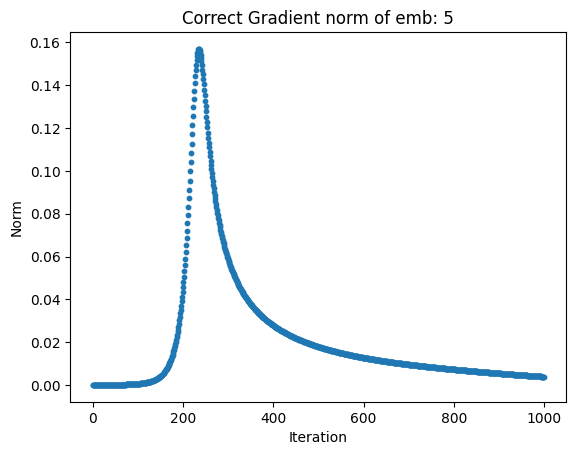

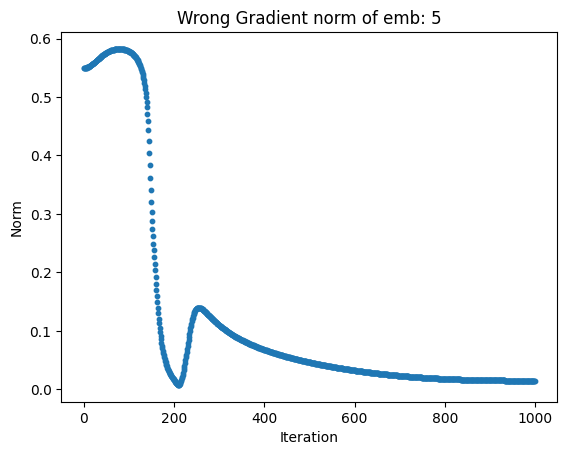

In [8]:
def plot_gradient(directory, node, type):
    """
    directory:      Directory with the gradients we want to plot
    node:           Int representing node we want to plot gradients of
    type:           String with the type of gradient (correct/wrong)
    """
    # Loop over all gradient files
    files = sorted(directory.iterdir(), key=lambda file: int(file.name.split(".")[0]))
    data_size = len(files)
    grads = np.zeros((data_size, 2))

    for idx, grad_file in enumerate(files):
        data = np.loadtxt(str(grad_file), delimiter=',')
        grads[idx] = data[node]

    # Establish x-coordinates
    xs = np.array([x for x in range(data_size)])   

    # Compute norms
    grads = np.linalg.norm(grads, axis=1)

    plt.scatter(xs, grads, s=10)
    plt.title(f"{type} Gradient norm of emb: {node}")
    plt.ylabel(f"Norm")
    plt.xlabel("Iteration")
    plt.show()

    # So we can use them for later
    return grads

# Plot correct gradient data of node {node}
node = 5
correct_grad_directory = Path("results/gradient_comparisons/cf_HyperbolicKL/correct_grad_True")
wrong_grad_directory = Path("results/gradient_comparisons/cf_HyperbolicKL/correct_grad_False")

grads_c = plot_gradient(correct_grad_directory, node, "Correct")
grads_w = plot_gradient(wrong_grad_directory, node, "Wrong")

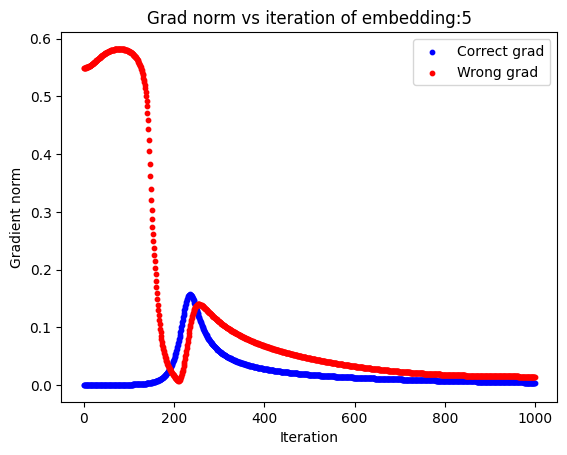

In [9]:
xs = np.array([x for x in range(grads_c.shape[0])])   
plt.scatter(xs, grads_c, s=10, c="blue", label="Correct grad")
plt.scatter(xs, grads_w, s=10, c="red", label="Wrong grad")

plt.title(f"Grad norm vs iteration of embedding:{node}")
plt.ylabel("Gradient norm")
plt.xlabel("Iteration")

plt.legend()
plt.show()

### Ideas to experiment further with
wg = wrong gradient, cg = correct gradient

1. It seems that the wg is in general much larger in magnitude than cg
2. wg starts off large, cg starts of small
3. cg peaks around iteration ~300
4. wg has a peak, but not a very obvious one like cg
5. When points are far away enough, i.e. when embeddings have converged, the gradients are more or less the same

### Initial ideas:
1. Lower iterations --> lower distances. Do smaller distances affect gradients?
2. $q^{H}_{ij}$ is very off at the beginning. I can analyze the relationship of $q^{H}_{ij}$ and gradient (norm)
3. In depthly investigate iteration (-1), seems to be the most straightforward place to start


### Gradient visualization

In [11]:
# Lets examine gradients of step 0
gradients_directory = Path("results/gradient_comparisons/cf_HyperbolicKL/")

# The iteration we want to analyze
emb_it = 500                              

# Load gradients corresponding to "emb_it"
data = dict()
for correct_grad in [True, False]:
    gradient_folder = Path(f"results/gradient_comparisons/cf_HyperbolicKL//correct_grad_{correct_grad}")
    # Load gradient data from the iteration we want
    gradient_file_path = Path(f"{gradient_folder}/{emb_it}.csv")
    gradient_data = np.loadtxt(str(gradient_file_path), delimiter=',')
    key = "Correct_Grad" if correct_grad else "Wrong_Grad"
    data[key] = gradient_data

# Load embedding corresponding to "emb_it"
embeddings_directory = Path("temp/poincare/correct_grad_True/solver_gradient_descent_sequential_opt_1")
emb_file_path = Path(f"{embeddings_directory}/{emb_it}.csv")
emb_data = np.loadtxt(str(emb_file_path), delimiter=',')
data["Emb"] = emb_data

FileNotFoundError: temp\poincare\correct_grad_True\solver_gradient_descent_sequential_opt_1\500.csv not found.

In [ ]:
# Testing data shape and such. Sanity checks

# for key in data:
#     print(key)
#     print(data[key])
#     print()

print(data["Emb"].shape)
print(data["Emb"][:, 0])
print(data["Emb"][0])
# Note that the indices of dataLabels correspond to indices of data["Emb"]
print(dataLabels)

So what do we do now with the data?

**data** contains computed gradients for each version, and the corresponding embedding 
- Embeddings are really close to eachother
- Zoom in, plot the points, and visualize the gradient vectors for each point?
- Compute angle differences between gradients? What parameters may be influencing this?

In [ ]:
from matplotlib import pyplot as plt

scaling_factor = 1
grad_scaling_factor = 1
wrong_grad_scaling_factor = 1

# Plot embedding points
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the embeddings/data
scaled_data = data["Emb"] * scaling_factor

# In our current situation we have 2 clusters with n_samples elements each
ax.scatter(scaled_data[:n_samples, 0], scaled_data[:n_samples, 1], color='red')
ax.scatter(scaled_data[n_samples:, 0], scaled_data[n_samples:, 1], color='blue')

# Plot the gradients 
scaled_wrong_grad = data["Wrong_Grad"] * wrong_grad_scaling_factor
ax.quiver(scaled_data[:, 0], scaled_data[:, 1], scaled_wrong_grad[:, 0], scaled_wrong_grad[:, 1],
          angles='xy', scale_units='xy', scale=1, color='green', label="wrong grad")

# Correct gradient seems to be ~3000 times smaller than wrong gradient (at the start)
scaled_correct_grad = data["Correct_Grad"] * grad_scaling_factor
ax.quiver(scaled_data[:, 0], scaled_data[:, 1], scaled_correct_grad[:, 0], scaled_correct_grad[:, 1],
          angles='xy', scale_units='xy', scale=1, color='purple', label="correct grad")

# Set axis limits
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Add labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Embedding it:{emb_it}')

ax.legend()

# Show the plot
plt.show()

In [ ]:
def compute_emb_probabilities(emb_data):
    Q = np.zeros((emb_data.shape[0], emb_data.shape[0]))

    # Note that Q is a symmetric matrix, so we only need to compute a diagonal half
    for i in range(0, Q.shape[0]):
        for j in range(i + 1, Q.shape[0]):
            # Compute embedding probability between (i, j)
            
            num = np.linalg.norm(emb_data[i] - emb_data[j])
            denum = (1 - np.linalg.norm(emb_data[i])) * (1 - np.linalg.norm(emb_data[j]))
            dist = np.arccosh(1 + 2 * (num / denum))
            t_distrib_dist = 1. / (1 + dist**2)
            Q[i][j] = t_distrib_dist
            Q[j][i] = t_distrib_dist
    
    return Q / Q.sum()


# Recomputing probability matrices
P_ij = V.toarray() 
Q_ij = compute_emb_probabilities(data["Emb"])

print(P_ij)
print()
print(Q_ij)

print(P_ij - Q_ij)

In [ ]:
# Print gradients of iteration emb_it
print("iteration: ", emb_it)
print()

# correct gradients
print("Correct Grads")
print(data["Correct_Grad"])
print()

# wrong gradients
print("Wrong Grads")
print(data["Wrong_Grad"])

In [ ]:
# High dimensional affinities
P = V

# Low dimensional affinities, computed from embeddings 
def hyp_dist(y1, y2):
    diff = y1 - y2
    num = diff.dot(diff)                         # numerator
    denum = (1 - y1.dot(y1)) * (1 - y2.dot(y2))  # denumerator
    dist = np.arccosh(1 + 2 * (num / denum))

    return dist

def compute_affinities(embedding_data):
    Q = np.zeros((embedding_data.shape[0], embedding_data.shape[0]))
    for i in range(Q.shape[0]):
        for j in range(i + 1, Q.shape[1]):
            dist = hyp_dist(embedding_data[i], embedding_data[j])       # hyp. distance
            dist = 1. / (1 + dist**2)                                   # t-distrib. "distance"
            Q[i][j] = dist
            Q[j][i] = dist

    # Normalize distances to probabilities
    # return Q / Q.sum()
    return Q / Q.sum()

Q = compute_affinities(data["Emb"])
print(Q)
print(data["Emb"])

# Analysis of behaviour at beginning (early iterations)

1. hyp. distances are small $d^{H}_{ij}$ approaches 0 (since $cosh^{-1} goes to 0), since its argument goes to 1.

2. This means t-distrib. probability goes to 1, $(1 + (d^{H}_{ij})^2)^{-1}$ goes to 1.
So once normalized, all probabilities $q^{H}_{ij}$ are almost the same for all $ij$, so we basically have an uniform distribution for $q^{H}_{ij}$

3. Why are the wrong gradients so much bigger?

Correct Gradient expression:
$$ 4  \sum_{j} (p_{ij} - q^{H}_{ij}) (1 + (d^{H}_{ij})^2)^{-1}  d^{H}_{ij} \frac{d^{H}_{ij}}{y_i}$$

\
Wrong Gradient expresion:
$$ 4  \sum_{j} (p_{ij} - q^{H}_{ij}) (1 + (d^{H}_{ij})^2)^{-1} \frac{d^{H}_{ij}}{y_i}$$

\
Because in early iterations, $ d^{H}_{ij} $ is approximately 0, the correct gradient is very small, until points haved moved sufficiently for this term to increase in value.

Can this possibly replace early exaggeration? Maybe.. 
At the beginning, points are updated in very small amounts. But this applies to both attractive and repulsive forces.

At some points, points are "distant" enough, for $ d^{H}_{ij} $ to not matter much anymore. 

$ d^{H}_{ij} $ goes up a lot (to possibly infinity) for larger distances. This means that forces between distant points get heavily amplified. Is this an issue though? Since very distant forces should be more or less 0?

4. Is the use of the t-distribution justified in hyperbolic space?
Is it making repellant points feel a repellant force for way too far distances?
What do p, q look like for points far away? Is the heavy-tailedness a problem in hyperbolic space?

Despite large distances, $ q^{H}_{ij} $ is never able to reach the "correct" probabilities due to the use of the t-distribution? Since the heavy tails requires too big of distances for things to converge properly. Hence points keep getting pushed out? 

We can try using a regular gaussian distribution for $ q^{H}_{ij} $. Rederive the gradient, and experiment with that.
But do we then need to take the symmetric version into account?

In [ ]:
# Lets analyze affinity matrices for later iterations. Points are farther away
# print(P.toarray())

# Load embedding corresponding to "emb_it"
emb_it = 998
embeddings_directory = Path("temp/poincare/correct_grad_True/solver_gradient_descent_sequential_opt_1")
emb_file_path = Path(f"{embeddings_directory}/{emb_it}.csv")
emb_data = np.loadtxt(str(emb_file_path), delimiter=',')
Q = compute_affinities(emb_data)

print(P.toarray()[0])
print() 

print(Q[0])
print()

print((P - Q)[0])

In [ ]:
print(emb_data)

y1 = emb_data[0]
y2 = emb_data[9]
print(y1, y2)

denum_y1 = (1 - y1.dot(y1))
denum_y2 = (1 - y2.dot(y2))
print(denum_y1, denum_y2)

diff = (y1 - y2).dot(y1 - y2)
print(diff)

frac = diff / (denum_y1 * denum_y2)
print(frac)

dist = np.arccosh(1 + 2 * frac)
print(dist)

dist = hyp_dist(y1, y2)
print(dist)